Let's try to sharpen the images or look at the surrounding area of each pixel to highlight areas that may have an issue. Then let's look at
trying to quantify the noise in each image.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()

powderthickness = 80
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
integrals = np.array([np.array(plt.imread(path)) for path in paths_sorted])[0:187]
print(np.shape(integrals))
del paths_sorted

(187, 2000, 2000)


In [73]:
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)
del coorddf
del objectCoordinates


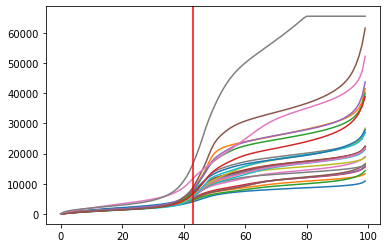

In [74]:
xs = np.arange(0, 100)
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    plt.plot(xs, np.percentile(integrals[:,object.ystart:object.yend, object.xstart:object.xend], xs))
plt.axvline(x=43, color='r', linestyle='-')

Let's use the spatial KD approach from the book.

In [75]:
import cv2
# This could also be a gaussian
windowSize = 7
emptyRatio = 43
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])/9
balanced = np.empty(np.shape(integrals))
balanced[:] = np.nan

for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    
    xs = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
    limit = np.percentile(xs, emptyRatio)
    filter = xs >= limit
    avg = np.mean(xs, where=filter)
    stddev = np.std(xs, where=filter)
    xs = (xs - avg) / stddev
    # plt.imshow(xs[93])
    # plt.title("Object " + str(object.Object) +
    #           " porosity " + str(object.Porosity) + 
    #           " mean " + str(avg) + " dev " + str(stddev/avg))
    # plt.figure()
    # print(np.mean(xs))
    # print(np.mean(integrals[:, object.ystart:object.yend, object.xstart:object.xend]))
    # plt.imshow(integrals[93, object.ystart:object.yend, object.xstart:object.xend] - xs[93])
    # plt.figure()
    balanced[:, object.ystart:object.yend, object.xstart:object.xend] = xs

(187, 2000, 2000)
187


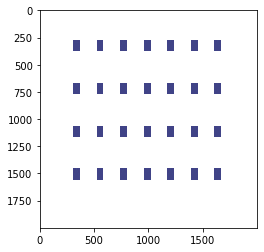

In [76]:
import cv2
# This could also be a gaussian
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])/9
veryBlurredLayers = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=kernel) for image in balanced])
print(np.shape(veryBlurredLayers))
plt.imshow(balanced[93] - veryBlurredLayers[93])
windowSize = 7
(endLayer, _, _) = veryBlurredLayers.shape
print(endLayer)
neighbourhoodValues = np.array([np.sum(veryBlurredLayers[layerIndex-windowSize:layerIndex], axis=0)/windowSize
                               for layerIndex in range(windowSize, endLayer)])
del veryBlurredLayers

/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_35635/2204905009.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


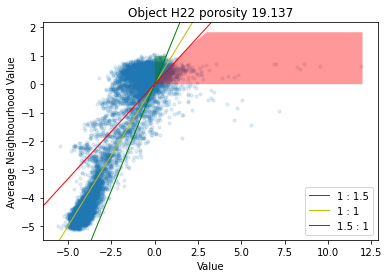

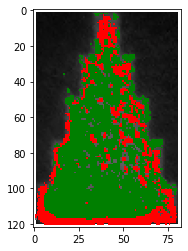

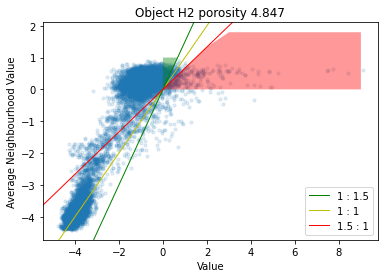

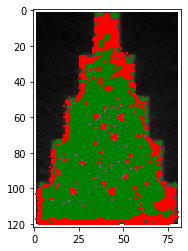

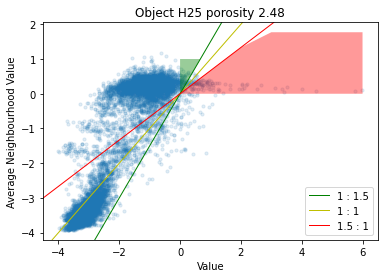

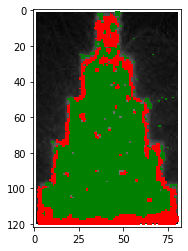

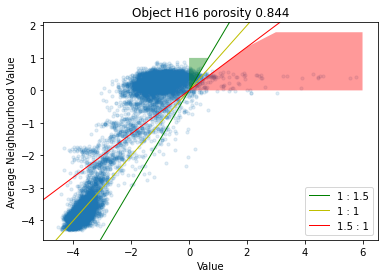

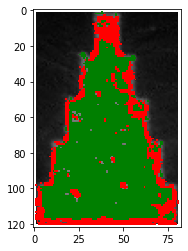

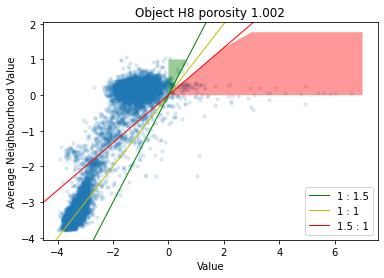

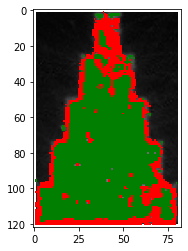

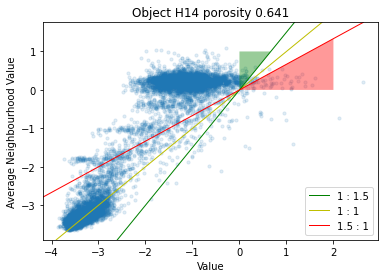

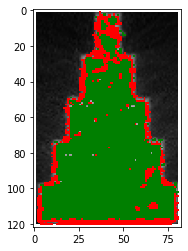

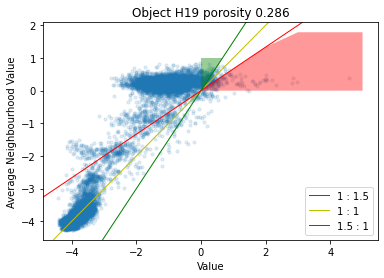

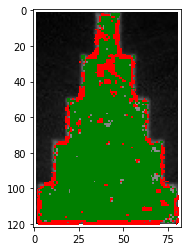

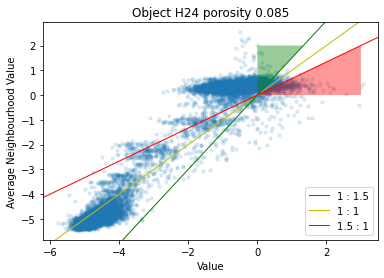

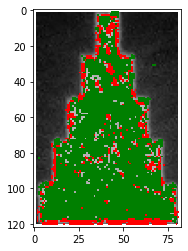

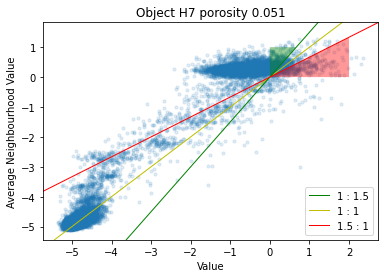

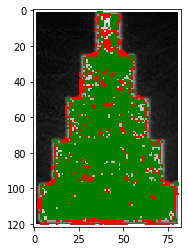

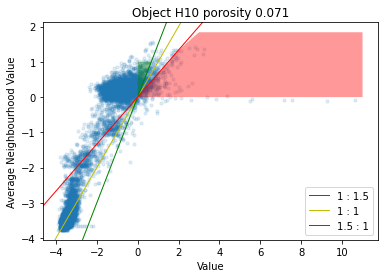

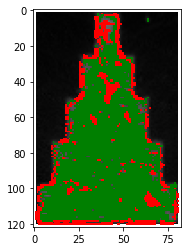

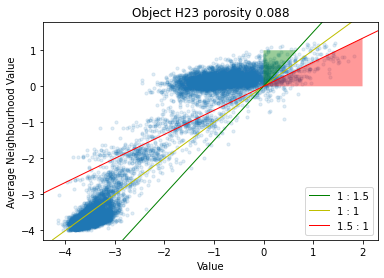

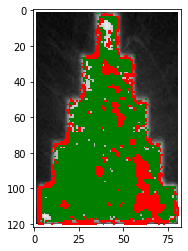

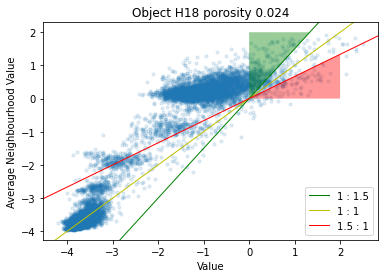

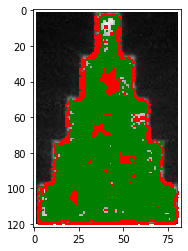

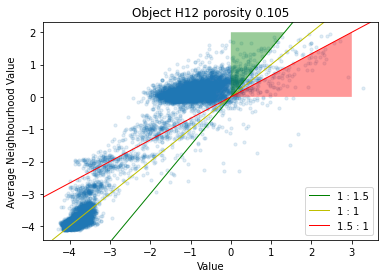

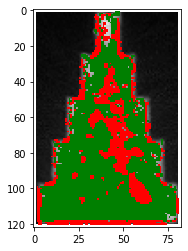

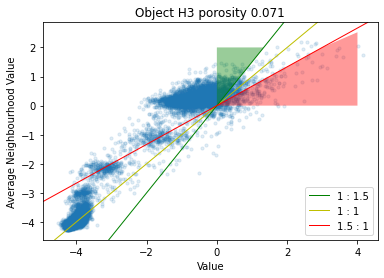

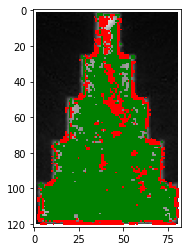

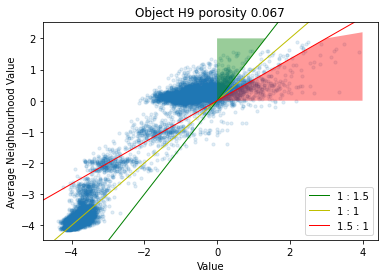

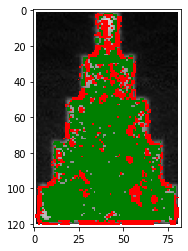

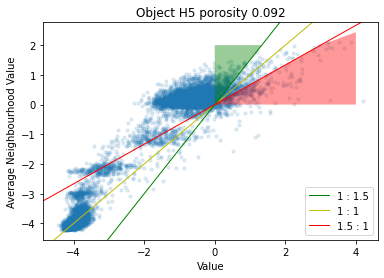

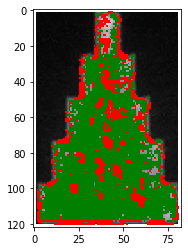

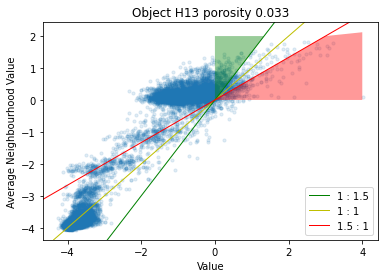

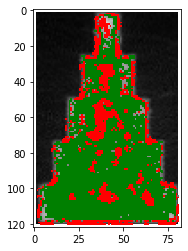

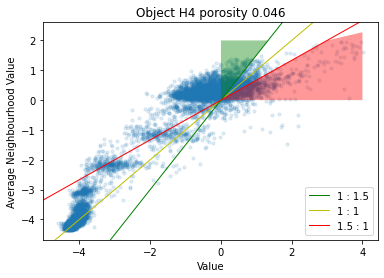

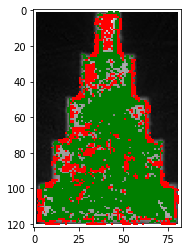

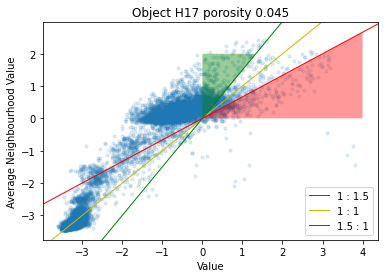

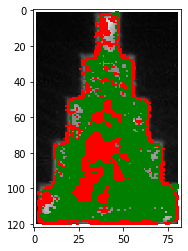

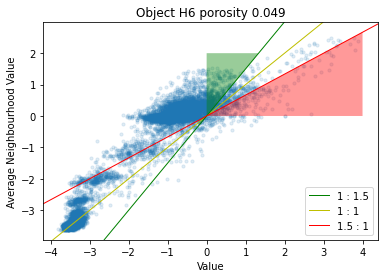

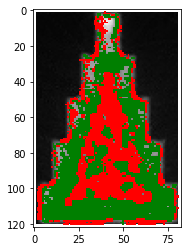

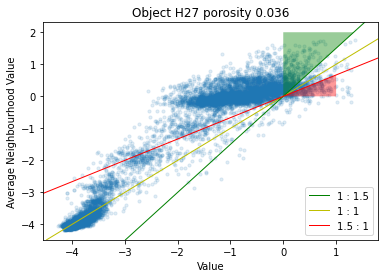

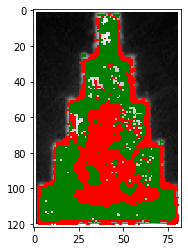

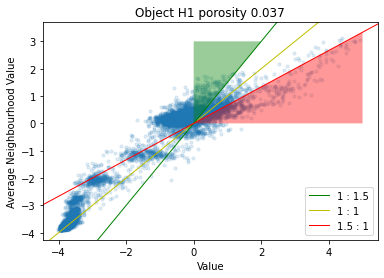

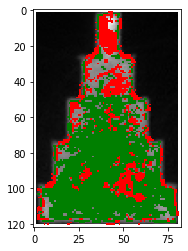

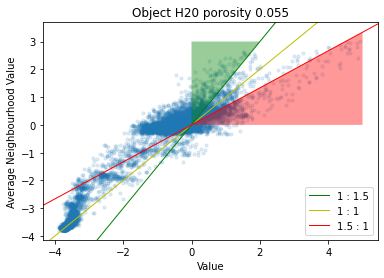

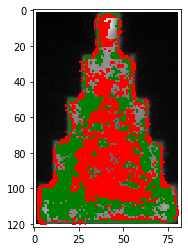

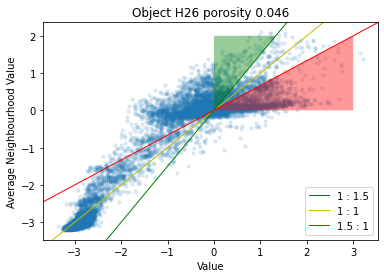

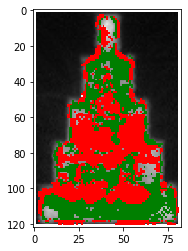

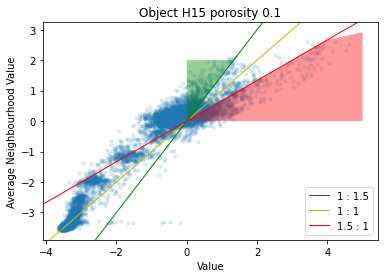

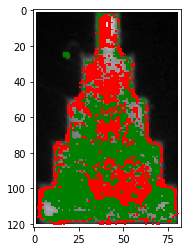

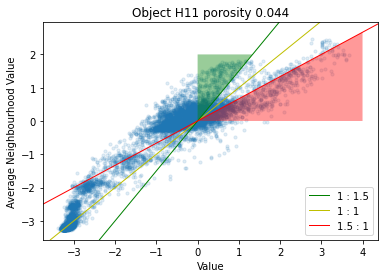

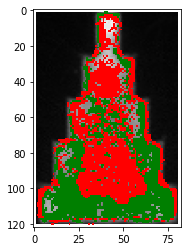

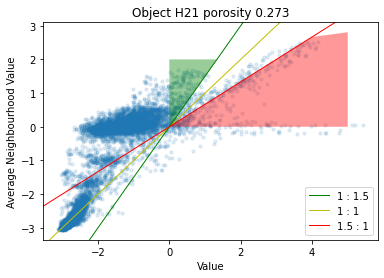

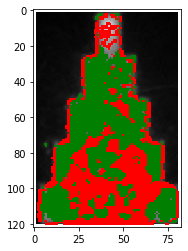

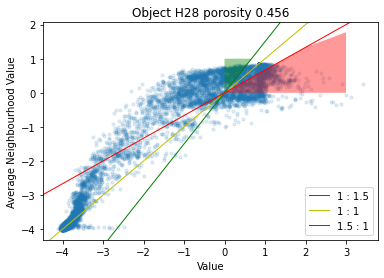

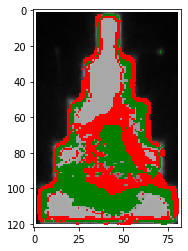

<Figure size 432x288 with 0 Axes>

In [77]:
objectinfo['lower_than_0.67'] = 0
objectinfo['lower_than_0.5'] = 0
objectinfo['higher_than_1.5'] = 0
objectinfo['higher_than_2'] = 0
objectinfo['total_1.5'] = 0
objectinfo['total_2'] = 0

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
layer = 93
image_sharp = cv2.filter2D(src=balanced[layer], ddepth=-1, kernel=kernel)
ncopy = np.copy(neighbourhoodValues[layer-windowSize-2])
# ncopy[ncopy < 5000] = 0
# image_sharp[ncopy < 5000] = 0

for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    #     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
    # xs = integrals[windowSize-1:endLayer-1, object.ystart:object.yend,object.xstart:object.xend]
    xs = image_sharp[object.ystart:object.yend, object.xstart:object.xend]
    ys = ncopy[object.ystart:object.yend, object.xstart:object.xend]
    limit = np.percentile(xs, emptyRatio)
    xs[ys < limit] = 0
    ys[ys < limit] = 0
    ratio = xs/ys
    objectinfo.at[index, 'lower_than_0.67'] = np.count_nonzero(
        (ratio < 1/1.5) & (xs > limit))
    objectinfo.at[index, 'higher_than_1.5'] = np.count_nonzero(
        (ratio > 1.5) & (xs > limit))
    objectinfo.at[index, 'lower_than_0.5'] = np.count_nonzero(
        (ratio < 1/2) & (xs > limit))
    objectinfo.at[index, 'higher_than_2'] = np.count_nonzero(
        (ratio > 2) & (xs > limit))
    objectinfo.at[index, 'total_1.5'] = np.count_nonzero(
        ((ratio < 1/1.5) | (ratio > 1.5)) & (xs > limit))
    objectinfo.at[index, 'total_2'] = np.count_nonzero(
        ((ratio < 1/2) | (ratio > 2)) & (xs > limit))
    plt.title("Object " + str(object.Object) +
              " porosity " + str(object.Porosity))
    plt.scatter(xs, ys, s=10, alpha=0.125)
    l1 = plt.axline((0, 0), (1, 1), linewidth=1, color='y')
    l2 = plt.axline((0, 0), (1, 1.5), linewidth=1, color='g')
    l3 = plt.axline((0, 0), (1.5, 1), linewidth=1, color='r')
    plt.xlabel("Value")
    plt.ylabel("Average Neighbourhood Value")
    plt.legend([l2, l1, l3], ['1 : 1.5', '1 : 1',
               '1.5 : 1'], loc="lower right")
    xmin, xmax, ymin, ymax = plt.axis()
    x = np.arange(0, xmax)
    x1 = x/1.5
    x1[x1 > ymax] = ymax
    y = np.arange(0, ymax)
    y1 = y/1.5
    y1[y1 > xmax] = xmax
    plt.fill_between(x, x1, 0, facecolor='r', alpha=0.4)
    plt.fill_betweenx(y, y1, 0, facecolor='g', alpha=0.4)
    plt.figure()

    plt.imshow(image_sharp[object.ystart:object.yend,
               object.xstart:object.xend], cmap="gray")
    
    # Start with higher
    my_cmap2 = copy(cm.get_cmap('gray'))
    my_cmap2.set_over('r')  # make locations over vmax translucent red
    # make location under vmin transparent white
    my_cmap2.set_under('w', alpha=0)
    # make location with invalid data green
    my_cmap2.set_bad('w', alpha=0)
    my_norm = colors.Normalize(vmin=1.5, vmax=1.5001, clip=False)
    plt.imshow(ratio, norm=my_norm, cmap=my_cmap2, interpolation='nearest')
    # then lower
    my_cmap = copy(cm.get_cmap('gray'))
    my_cmap.set_under('g')  # make locations over vmax translucent red
    # make location under vmin transparent white
    my_cmap.set_over('w', alpha=0)
    # make location with invalid data green
    my_cmap.set_bad('w')
    my_norm = colors.Normalize(vmin=0.6666, vmax=0.6667, clip=False)
    plt.imshow(ratio, norm=my_norm, cmap=my_cmap, interpolation='nearest')
    plt.figure()


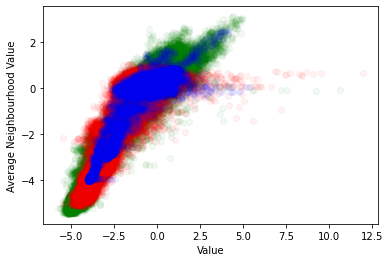

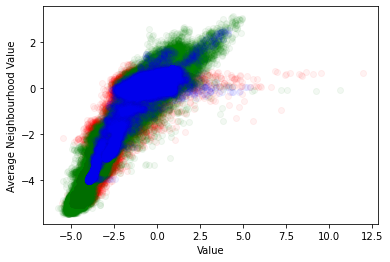

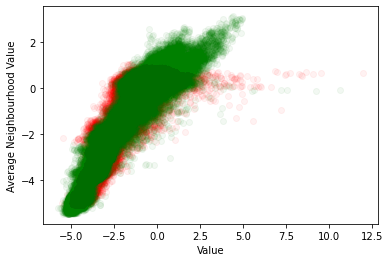

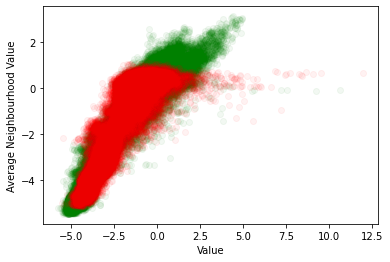

In [84]:
objectinfo['lower_than_0.67'] = 0
objectinfo['lower_than_0.5'] = 0
objectinfo['higher_than_1.5'] = 0
objectinfo['higher_than_2'] = 0
objectinfo['total_1.5'] = 0
objectinfo['total_2'] = 0

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
layer = 93
image_sharp = cv2.filter2D(src=balanced[layer], ddepth=-1, kernel=kernel)
ncopy = np.copy(neighbourhoodValues[layer-windowSize-2])
# ncopy[ncopy < 5000] = 0
# image_sharp[ncopy < 5000] = 0

poorx = []
poory = []
goodx = []
goody = []
hotx = []
hoty = []



for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    #     plt.title("Object " + str(object.Object) + " segment " + str(object.Segment))
    # xs = integrals[windowSize-1:endLayer-1, object.ystart:object.yend,object.xstart:object.xend]
    xs = image_sharp[object.ystart:object.yend, object.xstart:object.xend]
    ys = ncopy[object.ystart:object.yend, object.xstart:object.xend]
    if object.Porosity > 0.2:
        if object.VED < 35:
            poorx.append(xs)
            poory.append(ys)
        else:
            hotx.append(xs)
            hoty.append(ys)
    else:
        goodx.append(xs)
        goody.append(ys)
plt.figure()
plt.xlabel("Value")
plt.ylabel("Average Neighbourhood Value")
plt.scatter(goodx, goody, alpha=0.05, c='g')
plt.scatter(poorx, poory, alpha=0.05, c='r')
plt.scatter(hotx, hoty, alpha=0.05, c='b')
plt.figure()
plt.xlabel("Value")
plt.ylabel("Average Neighbourhood Value")
plt.scatter(poorx, poory, alpha=0.05, c='r')
plt.scatter(goodx, goody, alpha=0.05, c='g')
plt.scatter(hotx, hoty, alpha=0.05, c='b')
plt.figure()
plt.xlabel("Value")
plt.ylabel("Average Neighbourhood Value")
plt.scatter(poorx, poory, alpha=0.05, c='r')
plt.scatter(goodx, goody, alpha=0.05, c='g')
plt.figure()
plt.xlabel("Value")
plt.ylabel("Average Neighbourhood Value")
plt.scatter(goodx, goody, alpha=0.05, c='g')
plt.scatter(poorx, poory, alpha=0.05, c='r')


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_13699/1134675734.py:17: RuntimeWarning: invalid value encountered in true_divide
  ratio = xs/ys


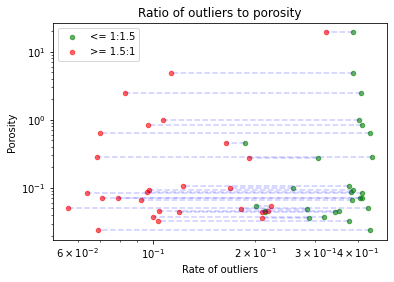

In [46]:
# Counts and prints a scatter plot of all

objectinfo['lower_than_0.67'] = 0
objectinfo['lower_than_0.5'] = 0
objectinfo['higher_than_1.5'] = 0
objectinfo['higher_than_2'] = 0
objectinfo['total_1.5'] = 0
objectinfo['total_2'] = 0
objectinfo['no_of_points'] = 0

for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    xs = image_sharp[object.ystart:object.yend, object.xstart:object.xend]
    ys = ncopy[object.ystart:object.yend, object.xstart:object.xend]
    limit = np.percentile(xs, 47)
    xs[ys < limit] = 0
    ys[ys < limit] = 0
    ratio = xs/ys
    objectinfo.at[index, 'no_of_points'] = np.count_nonzero((xs > limit))
    objectinfo.at[index, 'lower_than_0.67'] = np.count_nonzero(
        (ratio < 1/1.5) & (xs > limit))
    objectinfo.at[index, 'higher_than_1.5'] = np.count_nonzero(
        (ratio > 1.5) & (xs > limit))
    objectinfo.at[index, 'lower_than_0.5'] = np.count_nonzero(
        (ratio < 1/2) & (xs > limit))
    objectinfo.at[index, 'higher_than_2'] = np.count_nonzero(
        (ratio > 2) & (xs > limit))
    objectinfo.at[index, 'total_1.5'] = np.count_nonzero(
        ((ratio < 1/1.5) | (ratio > 1.5)) & (xs > limit))
    objectinfo.at[index, 'total_2'] = np.count_nonzero(
        ((ratio < 1/2) | (ratio > 2)) & (xs > limit))

plt.scatter(objectinfo['lower_than_0.67']/objectinfo['no_of_points'],
            objectinfo['Porosity'], c='g', s=20, alpha=0.6, label='<= 1:1.5')
plt.scatter(objectinfo['higher_than_1.5']/objectinfo['no_of_points'],
            objectinfo['Porosity'], c='r', s=20, alpha=0.6, label='>= 1.5:1')
for index, object in objectinfo.sort_values(by=['VED']).iterrows():
    xs = [object['lower_than_0.67']/object['no_of_points'],
          object['higher_than_1.5']/object['no_of_points']]
    ys = [object['Porosity'], object['Porosity']]
    plt.plot(xs, ys, linestyle='--', color='b', alpha=0.2)
plt.title('Ratio of outliers to porosity')
plt.legend()
plt.ylabel('Porosity')
plt.xlabel('Rate of outliers')
plt.yscale('log')
plt.xscale('log')